<a href="https://colab.research.google.com/github/DanielaaVargas/NINE/blob/main/NGC%205257.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Packages installation and import**


In [1]:
%%capture
!pip install astropy==5.3;
!pip install pyregion;
!pip install photutils;
!pip install regions;
!pip install scipy;
!pip install aplpy;

import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import pyregion
import scipy as sp
import scipy.ndimage
from astropy.coordinates import Angle
from astropy import units as u
from astropy.stats import SigmaClip
from photutils.background import StdBackgroundRMS
from regions import Regions
from pyregion import get_mask
import aplpy
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/MyDrive/NINE/Imaging/NGC5257/'

#**Galaxy NGC5257 Display with aplpy**

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.
INFO:astropy:Auto-setting vmin to -7.747e-05
INFO:astropy:Auto-setting vmax to  2.942e-04


INFO: Auto-setting vmin to -7.747e-05 [aplpy.core]
INFO: Auto-setting vmax to  2.942e-04 [aplpy.core]


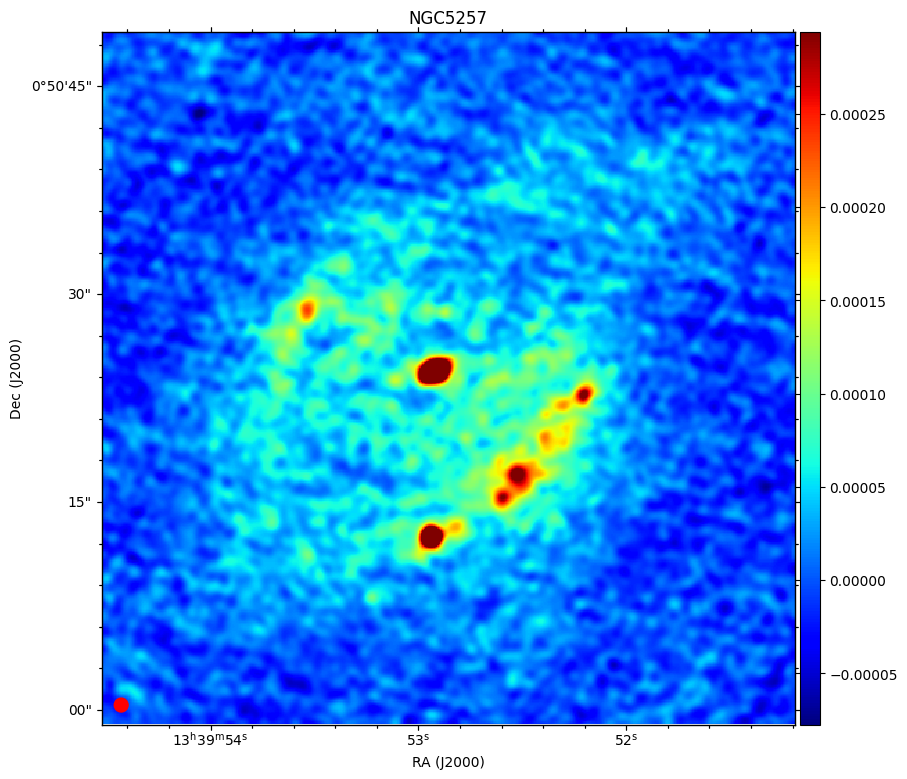

In [2]:
Image = path + 'NGC5257_s_concat.fits'

iMg = aplpy.FITSFigure(Image)
iMg.set_title("NGC5257")
iMg.show_colorscale(cmap='jet')
iMg.add_colorbar()
#iMg.add_grid()
iMg.add_beam()
iMg.beam.set_color('red')

# **Header Data Unit (HDU)**

This shows the metadata and information about the fits file.

**KEYWORDS**

 CRVALi stands for 'Coordinate Reference Value for the ith axis'

 CRPIXi stands for 'Coordinate Reference Pixel for the ith axis'

 CDELTi stands for 'Coordinate Increment per Pixel for the ith axis'

In [3]:
IMG = fits.open(Image)  #HDU List
PrimaryHDU = IMG[0]     #PrimaryHDU object

print(IMG)
print(IMG.info())
print(PrimaryHDU)

print('\nTotal intensity: ', PrimaryHDU.data.sum(), '\n')

PrimaryHDU.data

Filename: /content/drive/MyDrive/NINE/Imaging/NGC5257/NGC5257_s_concat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     464   (500, 500)   float32   
None

Total intensity:  5.0380697 



array([[ 8.26412725e-06,  1.11680338e-05,  1.26492369e-05, ...,
        -1.72429845e-05, -1.93974975e-05, -2.05095348e-05],
       [ 9.60668785e-06,  1.16774090e-05,  1.24986382e-05, ...,
        -1.34218863e-05, -1.55398520e-05, -1.68728329e-05],
       [ 9.51097627e-06,  1.08473023e-05,  1.12185162e-05, ...,
        -9.66556217e-06, -1.15705325e-05, -1.29631226e-05],
       ...,
       [-1.76731373e-05, -1.96667279e-05, -2.22559920e-05, ...,
        -1.09307339e-05, -1.17784193e-05, -1.12150310e-05],
       [-1.63994009e-05, -1.73223671e-05, -1.93626838e-05, ...,
        -9.35070511e-06, -8.95358426e-06, -7.01617500e-06],
       [-1.33105677e-05, -1.31605584e-05, -1.46572456e-05, ...,
        -8.54498649e-06, -6.71585485e-06, -3.33423918e-06]], dtype='>f4')

In [4]:
header = PrimaryHDU.header
header

n = 55
# Open the FITS file
with fits.open(Image) as hdul:
    # Get the header of the primary HDU (Header/Data Unit)
    header = hdul[0].header

    # Print the first n lines of the header
    for i in range(n):
        print(header.cards[i])

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  500                                                  
NAXIS2  =                  500                                                  
BMAJ    =   2.777777777778E-04                                                  
BMIN    =   2.777777777778E-04                                                  
BPA     =   0.000000000000E+00                                                  
BTYPE   = 'Intensity'                                                           
OBJECT  = 'NGC 5257/8'                                                          
BUNIT   = 'Jy/beam '           /Brightness (pixel) unit                         
EQUINOX =   2.000000000000E+03                                                  
RADESYS = 'FK5     '        

# **Noise Characterization**

It is possible to calculate the average noise of a fits file.

In [5]:
Regions = path + 'NGC5257_regions'

vla = fits.getdata(Image)
data = PrimaryHDU.data
print(vla.shape, '\n')

reg = pyregion.open(Regions)
reg

(500, 500) 



[Shape : circle ( Number(350),Number(397),Number(27.365644) ),
 Shape : circle ( Number(125),Number(411),Number(26.173982) ),
 Shape : circle ( Number(339),Number(125),Number(16.653777) ),
 Shape : circle ( Number(409),Number(268),Number(22.080492) ),
 Shape : circle ( Number(58),Number(340),Number(21.239387) ),
 Shape : circle ( Number(84),Number(100),Number(15.103383) ),
 Shape : circle ( Number(393),Number(351),Number(20.240946) ),
 Shape : circle ( Number(219),Number(428),Number(23.223071) ),
 Shape : circle ( Number(165),Number(82),Number(13.608443) ),
 Shape : circle ( Number(414),Number(164),Number(20.20268) ),
 Shape : circle ( Number(422),Number(404),Number(20.944396) ),
 Shape : circle ( Number(38),Number(171),Number(15.396219) )]

In [6]:
rms_values = []
for n in range(len(reg)):
  reg = pyregion.open(Regions)
  del reg[0:n]  #deletes only the first element of the list in each loop
  m=len(reg)
  del reg[1:m]  #leaves only the first element of the list in each loop
  mask = reg.get_mask(shape = vla.shape, header = header)
  mask = get_mask(reg, data)
  maskdata = np.multiply(vla, mask)
  N = len(maskdata[maskdata!=0])
  rms_values.append(np.sqrt(np.sum(maskdata**2)/N))
avg_rms = np.mean(rms_values)
avg_rms  #Average noise

2.341348137395463e-05

In [7]:
maskdata[maskdata!=0]
mask[1][mask[1]==True]
maskdata

array([[ 0.,  0.,  0., ..., -0., -0., -0.],
       [ 0.,  0.,  0., ..., -0., -0., -0.],
       [ 0.,  0.,  0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]], dtype=float32)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.



How many contours do you want to do? 1

	CONTOUR 1
How many average rms above? 5

Color black


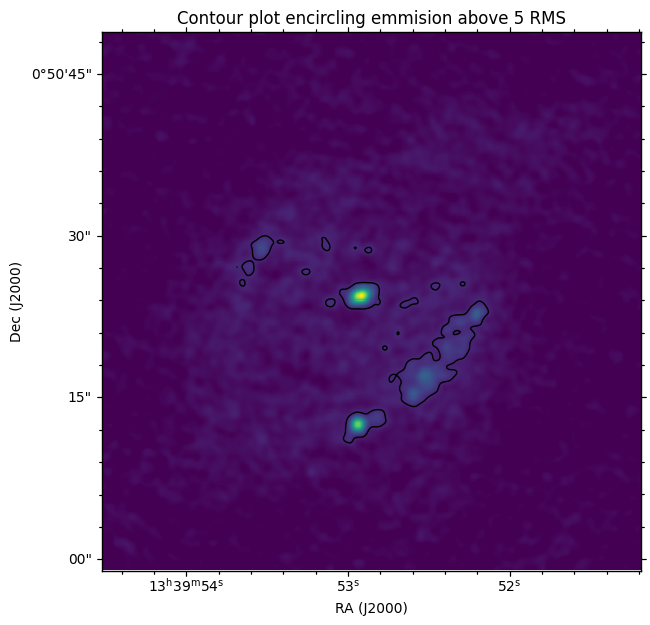

In [8]:
fig = aplpy.FITSFigure(Image, figure=plt.figure(figsize=(7,7)))
fig.show_colorscale(vmin=0, vmax=np.max(vla), stretch='linear')

contours = int(input('\nHow many contours do you want to do? '))
rms = []
for n in range(contours):
  n = int(input(f'\n\tCONTOUR {n+1}\nHow many average rms above? '))
  color = input('\nColor ')
  fig.show_contour(data=vla, levels=[n*avg_rms], colors=[color], linewidths=1.0)
  rms.append(n)
1
rms_string = ','.join(map(str, rms))
fig.set_title(f'Contour plot encircling emmision above {rms_string} RMS')

# **Photometry**

This refers to the measurement of the intensity of the source.

In [9]:
# Parameters (in degrees) from the header
bmaj_deg = header['BMAJ']
bmin_deg = header['BMIN']
pxSize = header['CDELT1']

# Area of a Gaussian Beam in square degrees
beam_deg = np.pi * bmaj_deg * bmin_deg / (4*np.log(2))

# Conversion: Beam's area to square pixels
px_deg = pxSize**2
beam_px = beam_deg / px_deg
print("Area of the beam in pixels: ", beam_px)

# Considering a pixel significant if its emission is above 3-sigma
signif_px = vla[vla > 3 * avg_rms]

# The total emission is given by the sum of the significant pixels
T_emission_jy = np.sum(signif_px)  # S_v in Jy
print("\nTotal emission of the galaxy in Jy:", T_emission_jy)

# TOTAL LUMINOSITY (energy per unit time hitting a detector) in solar luminosities

d_pc = 98e6  # distance between Earth and the NGC5258 galaxy
d_cm = d_pc*3.086e18
T_emission_erg = (T_emission_jy / beam_px)*1e-23  #B_v in erg
solarluminosity = 3.827e33 # Conversion factor: solar luminosities in erg/s
T_luminosity_sl = T_emission_erg * 4 * np.pi * d_cm**2 / solarluminosity
"""This is a conversion from erg to sl, and multiplying by the sun's
   surface area eliminates the area factor from the total emission B_v"""

print("\nTotal luminosity in solar luminosities:", T_luminosity_sl)

#total_emission_erg
print('\nTotal emission in Jy: ', T_emission_jy/beam_px) #also eliminates the area factor from S_v

Area of the beam in pixels:  113.30900354567986

Total emission of the galaxy in Jy: 2.4700563

Total luminosity in solar luminosities: 6.546931964233713e-05

Total emission in Jy:  0.021799294125811535


# **Data Cubes**

In [56]:
Cube = path + 'NGC_5257_cube_1arcsec_inregion.pbcor_hcorr.fits'
print(fits.open(Cube))

#data and header
Cb_data = fits.open(Cube)[0].data
Cb_header = fits.open(Cube)[0].header

print(Cb_data.shape)  # (n_channels, n_y_pixels, n_x_pixels)
"""NAXIS is a keyword specifying the number of dimensions in the data array.
    It is part of the header of the FITS file."""
n_channels = Cb_header['NAXIS3']
n_y_pixels = Cb_header['NAXIS2']
n_x_pixels = Cb_header['NAXIS1']

with fits.open(Cube) as hdul:
    primary_header = hdul[0].header

header_list = [(key, primary_header[key], primary_header.comments[key]) for key in primary_header]

df = pd.DataFrame(header_list, columns = ['Keyword', 'Value', 'Comment'])

print(df.head(51))

(450, 500, 500)
     Keyword                       Value                     Comment
0     SIMPLE                        True   conforms to FITS standard
1     BITPIX                         -32             array data type
2      NAXIS                           3  number of array dimensions
3     NAXIS1                         500                            
4     NAXIS2                         500                            
5     NAXIS3                         450                            
6       BMAJ                    0.000278                            
7       BMIN                    0.000278                            
8        BPA                         0.0                            
9      BTYPE                   Intensity                            
10    OBJECT                    NGC_5257                            
11     BUNIT                     Jy/beam                            
12   RADESYS                        ICRS                            
13   LONPOLE      

In [11]:
print(Cb_data[1,:,:])
#RESTFRQ of a spectral line is the frequency at which the line would be observed if the source were at rest relative to the observer.
V_d = (1-Cb_header['CRVAL3']/Cb_header['RESTFRQ'])*2.99999e5                                                 #converts central freq to velocity
V_u = (1-(Cb_header['CRVAL3'] + Cb_header['CDELT3']*Cb_header['NAXIS3'])/Cb_header['RESTFRQ'])*2.99999e5     #calculates the lower frequency
deltaV = (V_u - V_d)/Cb_header['NAXIS3']
print("\nV_d:", V_d, "\nV_u:", V_u, "\ndeltaV:", deltaV)

print('\nThe number of channels in the data cube is: ' + str(n_channels))

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]

V_d: 6104.20259472077 
V_u: 7455.132677162913 
deltaV: 3.002066849871428

The number of channels in the data cube is: 450


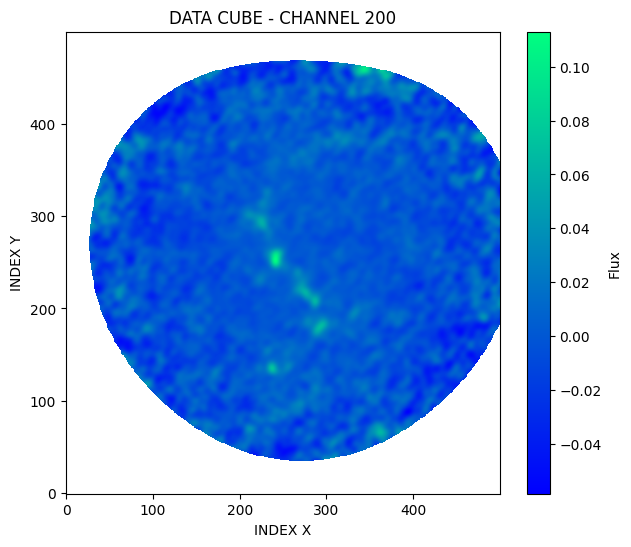

In [12]:
# This is a slice of the cube at channel 200,
# Shows the emission from the galaxy at the corresponding velocity at that slice
channel_index = 200
plt.figure(figsize=(7,6))
plt.imshow(Cb_data[channel_index], origin='lower', cmap='winter', aspect='auto')

#set labels
plt.xlabel('INDEX X')
plt.ylabel('INDEX Y')
plt.title(f'DATA CUBE - CHANNEL {channel_index}')

#show the figure of cube
plt.colorbar(label='Flux')

In [13]:
region_cube = path + 'NGC5257_REGION'
region1 = pyregion.open(region_cube)
region1


[Shape : circle ( Number(97),Number(397),Number(22.966935) ),
 Shape : circle ( Number(173),Number(363),Number(16.215455) ),
 Shape : circle ( Number(210),Number(402),Number(19.643496) ),
 Shape : circle ( Number(401),Number(289),Number(20.522484) ),
 Shape : circle ( Number(368),Number(147),Number(17.101821) ),
 Shape : circle ( Number(414),Number(179),Number(14.743665) ),
 Shape : circle ( Number(90),Number(343),Number(15.311889) ),
 Shape : circle ( Number(300),Number(101),Number(9.2847789) ),
 Shape : circle ( Number(53),Number(160),Number(7.6291135) ),
 Shape : circle ( Number(232),Number(76),Number(15.122511) )]

# **Emission Lines**

**KEYWORDS**

 CRVALi stands for 'Coordinate Reference Value for the ith axis'

 CRPIXi stands for 'Coordinate Reference Pixel for the ith axis'

 CDELTi stands for 'Coordinate Increment per Pixel for the ith axis'

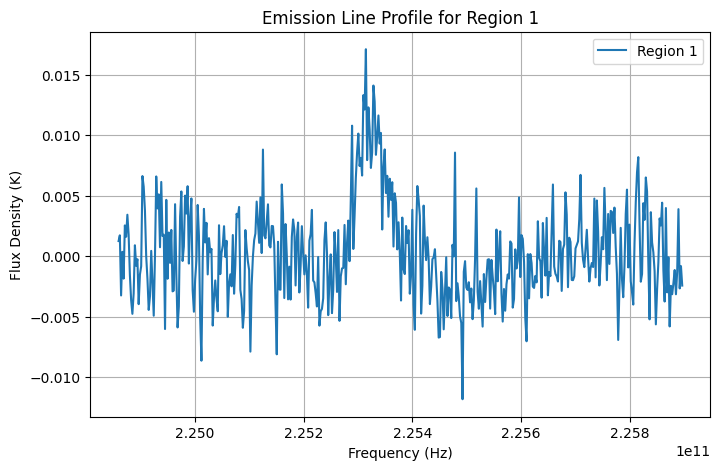

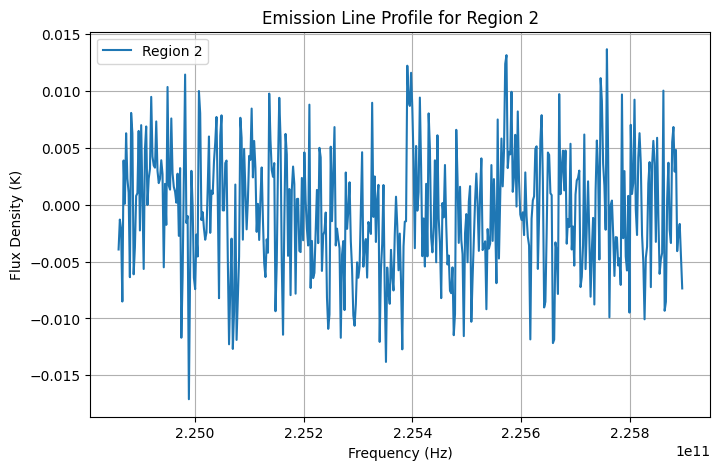

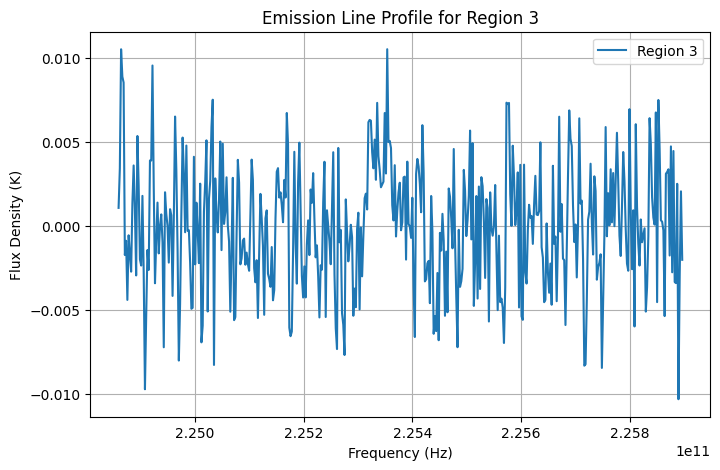

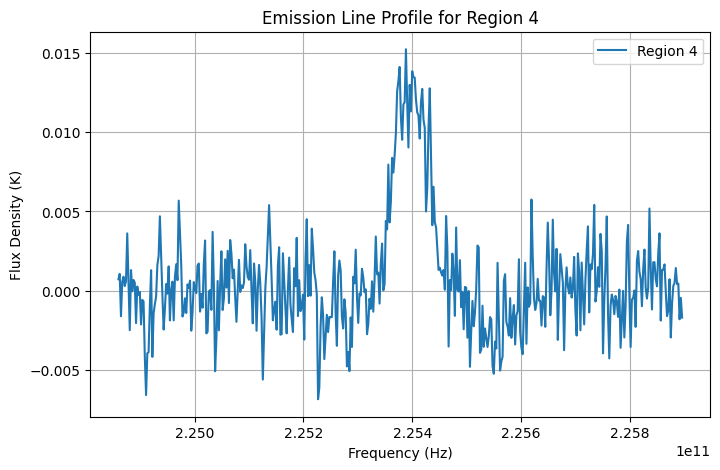

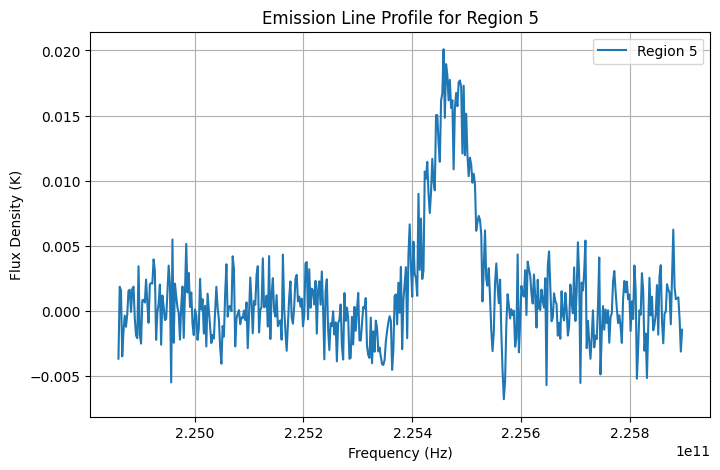

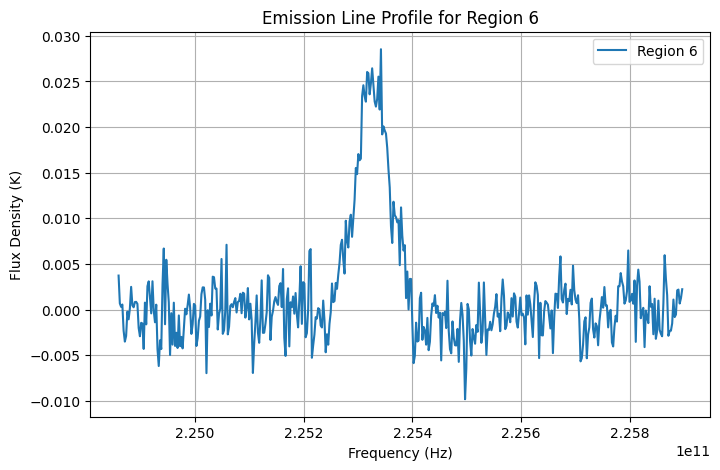

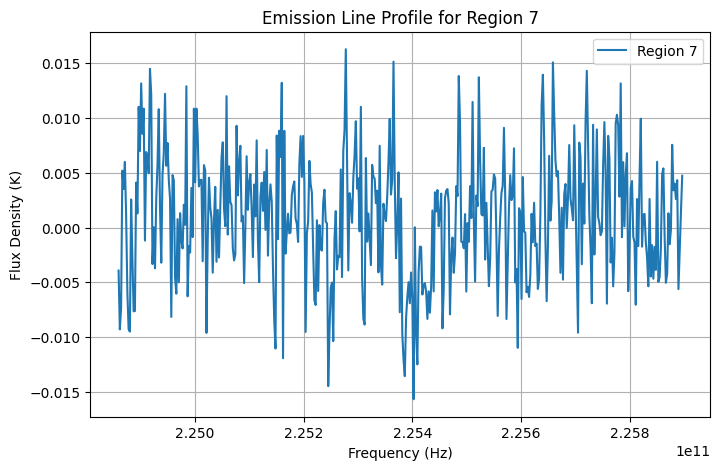

In [58]:
frequency = Cb_header['CRVAL3'] + (np.arange(Cb_header['NAXIS3']) - Cb_header['CRPIX3'] + 1) * Cb_header['CDELT3']
vla_cube = fits.getdata(Cube)

x, y, radius = 167, 320, 20
x1, y1, radius1 = 360, 125, 20
x2, y2, radius2 = 342, 160, 20
x3, y3, radius3 = 249, 224, 20
x4, y4, radius4 = 305, 210, 20
x5, y5, radius5 = 188, 265, 20
x6, y6, radius6 = 164, 385, 20

#Function to generate masks with the specified radius and coordinates.
def generate_circular_mask(shape, center_x, center_y, radius):
    y, x = np.ogrid[:shape[0], :shape[1]]
    masko = (x - center_x)**2 + (y - center_y)**2 <= radius**2
    return masko
#Function to calculate emission lines within the masked regions
def calculate_emission_line(masko):
    spectrum = np.nanmean(vla_cube[:, masko], axis=1)
    return frequency, spectrum
#Function to plot the emission lines
def plot_emission_line(region, frequency, spectrum):
    plt.figure(figsize = (8, 5))
    plt.plot(frequency, spectrum, label = '{}'.format(region))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Flux Density (K)')
    plt.title('Emission Line Profile for {}'.format(region))
    plt.legend()
    plt.grid()
    plt.show()

masko = generate_circular_mask(vla_cube.shape[1:], x, y, radius)
masko1 = generate_circular_mask(vla_cube.shape[1:], x1, y1, radius1)
masko2 = generate_circular_mask(vla_cube.shape[1:], x2, y2, radius2)
masko3 = generate_circular_mask(vla_cube.shape[1:], x3, y3, radius3)
masko4 = generate_circular_mask(vla_cube.shape[1:], x4, y4, radius4)
masko5 = generate_circular_mask(vla_cube.shape[1:], x5, y5, radius5)
masko6 = generate_circular_mask(vla_cube.shape[1:], x6, y6, radius6)

frequency, spectrum = calculate_emission_line(masko)
plot_emission_line('Region 1', frequency, spectrum)

frequency, spectrum = calculate_emission_line(masko1)
plot_emission_line('Region 2', frequency, spectrum)

frequency, spectrum = calculate_emission_line(masko2)
plot_emission_line('Region 3', frequency, spectrum)

frequency, spectrum = calculate_emission_line(masko3)
plot_emission_line('Region 4', frequency, spectrum)

frequency, spectrum = calculate_emission_line(masko4)
plot_emission_line('Region 5', frequency, spectrum)

frequency, spectrum = calculate_emission_line(masko5)
plot_emission_line('Region 6', frequency, spectrum)

frequency, spectrum = calculate_emission_line(masko6)
plot_emission_line('Region 7', frequency, spectrum)

In [67]:
print(vla_cube[~np.isnan(vla_cube)])

[0.0300132  0.03153559 0.0321851  ... 0.01809144 0.01710421 0.01523245]


# **Moment Maps**

In [80]:
phtcell = False

if phtcell:
  # Function to calculate the rms of an array
  def rms_function(array):
      N = len(array)
      rmS = np.sqrt(np.sum(array**2)/N)
      return rmS

  # Clipping function
  def clipper(array, rms, pb_mask):
      clipped_array = np.zeros([array.shape[0], array.shape[1], array.shape[2]])
      for k in range(0, array.shape[0], 1):
          array[k,:,:] = np.multiply(pb_mask, array[k,:,:])  # this multiplies the region with the array to mask it
          for i in range(0, array.shape[1], 1):
              for j in range(0, array.shape[2], 1):
                  if array[k,i,j] >= rms:
                      clipped_array[k,i,j] = array[k,i,j]
                  else:
                      clipped_array[k,i,j] = 0
      return clipped_array

  # Function that returns the moments
  def moments(cube,factor, pb_mask):
      cube_data    = cube.data
      header       = cube.header
      cube_data    = np.nan_to_num(cube_data)
      del header['HISTORY']

      v = cube_data.shape[0]
      x = cube_data.shape[1]
      y = cube_data.shape[2]
      V_d        = (1-header['CRVAL3']/header['RESTFRQ'])*2.99999e5                                         # converts central freq to velocity
      V_u        = (1-(header['CRVAL3']+header['CDELT3']*header['NAXIS3'])/header['RESTFRQ'])*2.99999e5     # calculates the upper frequency
      deltaV     = (V_u-V_d)/header['NAXIS3']

      slice_1    = cube_data[4,:,:]
      slice_2    = cube_data[-4,:,:]

      rms        = 0.5*(rms_function(slice_1) + rms_function(slice_2))    #correct dividing by no of pixels in a beam

      cube_data  = clipper(cube_data,factor*0.008, pb_mask)

      v_axis     = np.linspace(0, v-1, v, dtype=int)
      M0   = np.zeros([x,y])
      M1   = np.zeros([x,y])
      M2   = np.zeros([x,y])
      vl   = np.linspace(V_d, V_u, v)
      for i in range(0, x, 1):
          for j in range(0, y, 1):
              M0[i,j] = scipy.integrate.simps(cube_data[:,i,j], v_axis)*deltaV
              M1[i,j] = (scipy.integrate.simps(vl*cube_data[:,i,j], v_axis)*deltaV)/M0[i,j]
              M2[i,j] = np.sqrt((scipy.integrate.simps(cube_data[:,i,j]*(vl-M1[i,j])**2, v_axis)*deltaV)/M0[i,j])

      new_header          = header
      new_header['NAXIS'] = 2
      del new_header['NAXIS3']
      del new_header['CTYPE3']
      del new_header['CRVAL3']
      del new_header['CDELT3']
      del new_header['CRPIX3']
      del new_header['CUNIT3']
      del new_header['PC4_1']
      del new_header['PC4_2']
      del new_header['PC1_4']
      del new_header['PC2_4']
      del new_header['PC4_4']

      mom_0 = fits.PrimaryHDU(M0.astype('float'), new_header)
      mom_1 = fits.PrimaryHDU(M1.astype('float'), new_header)
      mom_2 = fits.PrimaryHDU(M2.astype('float'), new_header)
      return mom_0,mom_1,mom_2

In [ ]:
# Mask around the galaxy to eliminate noise
a = """image; circle({},{},{})""".format(265,255,100)
region = []
region.append(a)
r = pyregion.parse(region[0])
envelope_mask = r.get_mask(shape=[500, 500])

# Calculating the moments from the FITS file
cube  = fits.open(path + 'NGC_5257_cube_1arcsec_inregion.pbcor_hcorr.fits')[0]
moment_0, moment_1, moment_2 = moments(cube, 5, envelope_mask)

<ipython-input-143-462819e80268>:6: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  y = sp.ndimage.filters.gaussian_filter(image_data, [smoothing_factor,smoothing_factor], mode='constant')
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.
INFO:astropy:Auto-setting vmin to -3.208e-05
INFO:astropy:Auto-setting vmax to  1.717e-04


INFO: Auto-setting vmin to -3.208e-05 [aplpy.core]
INFO: Auto-setting vmax to  1.717e-04 [aplpy.core]


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.
INFO:astropy:Auto-setting vmin to -1.000e-01
INFO:astropy:Auto-setting vmax to  1.110e+00


INFO: Auto-setting vmin to -1.000e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.110e+00 [aplpy.core]


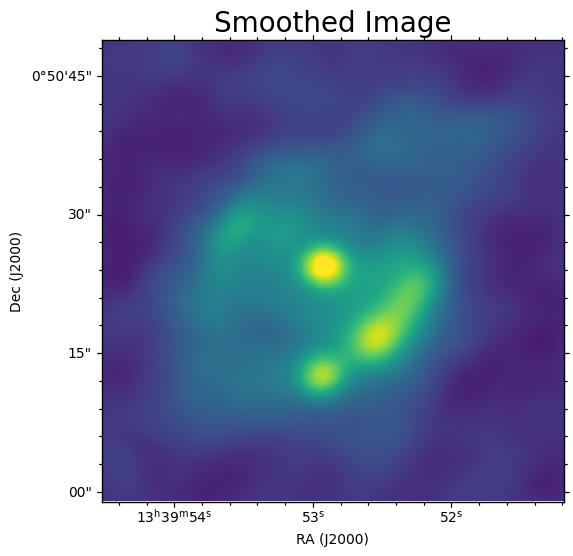

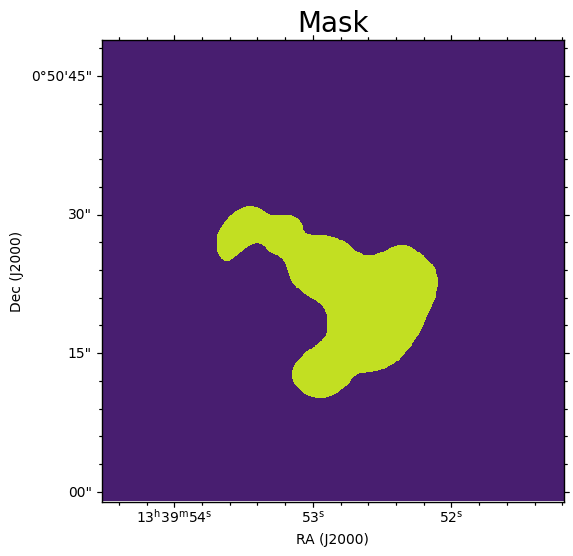

In [143]:
image = fits.open(path + 'NGC5257_s_concat_uvt_dot75asec_rbeam1asec_csdot1.pbcor_hcorr.fits')[0]
image_data  = image.data
image_header= image.header
smoothing_factor = 15

y = sp.ndimage.filters.gaussian_filter(image_data, [smoothing_factor,smoothing_factor], mode='constant')

smoothed_image = fits.PrimaryHDU(y.astype('float'), image_header)
smoothed_image_data = smoothed_image.data

#Smoothed image
fig = aplpy.FITSFigure(smoothed_image, figsize=(6, 6))
fig.set_title('Smoothed Image',fontsize=20)
fig.show_colorscale(cmap='viridis')

#Mask
x = image_data.shape[0]
y = image_data.shape[1]
mask = np.zeros([x,y],type(bool))
rms = 7.e-5

for i in range (0,x,1):
    for j in range (0,y,1):
        if smoothed_image_data[i,j] >= rms:
            mask [i,j] = True
        else:
            mask [i,j] = False

mask_hdu = fits.PrimaryHDU(mask.astype('float'), image_header)
fig = aplpy.FITSFigure(mask_hdu, figsize = (6, 6))
fig.set_title('Mask',fontsize = 20)
fig.show_colorscale(cmap = 'viridis')


In [145]:
cube = fits.open(path + 'NGC_5257_cube_1arcsec_inregion.pbcor_hcorr.fits')[0]
momento_0, momento_1, momento_2 = moments(cube,5,mask_hdu.data)

<ipython-input-78-9d5174aad662>:50: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  M0[i,j] = scipy.integrate.simps(cube_data[:,i,j], v_axis)*deltaV
<ipython-input-78-9d5174aad662>:51: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  M1[i,j] = (scipy.integrate.simps(vl*cube_data[:,i,j], v_axis)*deltaV)/M0[i,j]
<ipython-input-78-9d5174aad662>:51: RuntimeWarning: invalid value encountered in scalar divide
  M1[i,j] = (scipy.integrate.simps(vl*cube_data[:,i,j], v_axis)*deltaV)/M0[i,j]
<ipython-input-78-9d5174aad662>:52: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  M2[i,j] = np.sqrt((scipy.integrate.simps(cube_data[:,i,j]*(vl-M1[i,j])**2, v_axis)*deltaV)/M0[i,j])


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


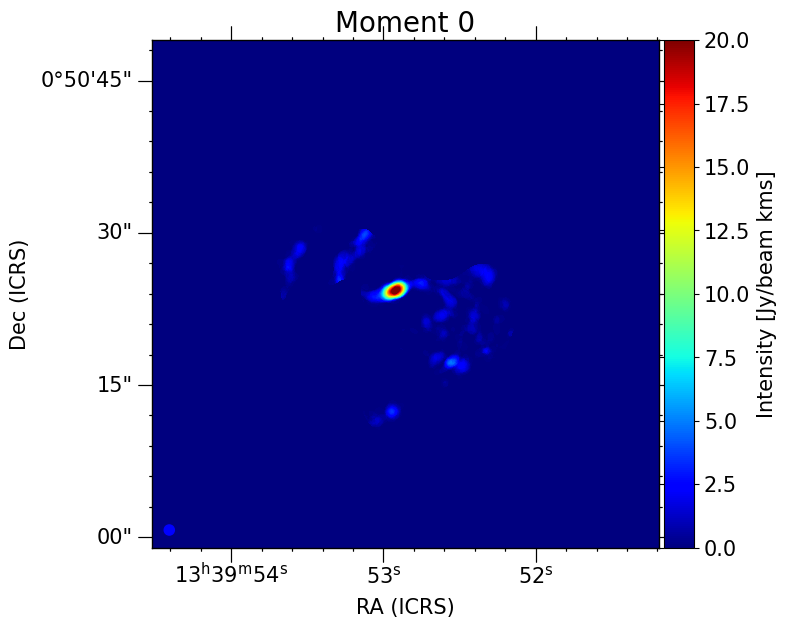

In [144]:
fig = aplpy.FITSFigure(momento_0, figsize=(7, 7))
fig.set_title('Moment 0',fontsize=20)
fig.show_colorscale(cmap='jet', vmin =0,vmax = 20)
fig.add_colorbar()
fig.colorbar.set_location('right')
fig.colorbar.set_width(0.3)
fig.colorbar.set_font(size='15')
fig.colorbar.set_axis_label_text('Intensity [Jy/beam kms]')
fig.colorbar.set_axis_label_font(size=15)
fig.axis_labels.set_font(size=15)
fig.tick_labels.set_font(size=15)
fig.ticks.set_length(10)
fig.add_beam()
fig.beam.set_color('blue')

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


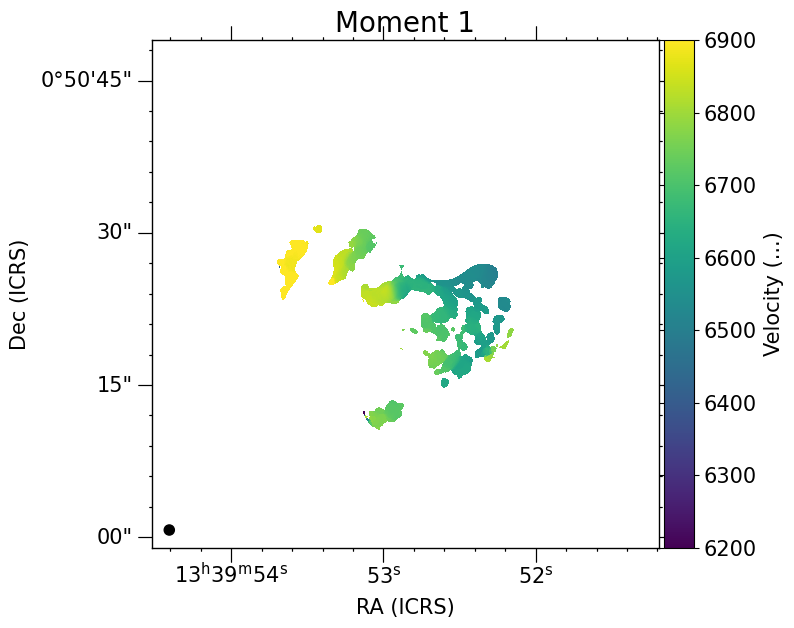

In [134]:
fig = aplpy.FITSFigure(momento_1, figsize=(7, 7))
fig.set_title('Moment 1',fontsize=20)
fig.show_colorscale(cmap ='viridis', vmin = 6200,vmax = 6900)
fig.add_colorbar()
fig.colorbar.set_location('right')
fig.colorbar.set_width(0.3)
fig.colorbar.set_font(size='15')
fig.colorbar.set_axis_label_text('Velocity (...)')
fig.colorbar.set_axis_label_font(size=15)
fig.axis_labels.set_font(size=15)
fig.tick_labels.set_font(size=15)
fig.ticks.set_length(10)
fig.add_beam()
fig.beam.set_color('black')


In [135]:
M1 = momento_1.data
M1[np.isnan(M1)] = 0
np.max(M1)
np.min(M1)
np.median(M1)
np.min(M1[M1!=0])

6122.255112526233

In [136]:
M2 = momento_2.data
M2[np.isnan(M2)] = 0
np.max(M2)
#np.min(M2)
#np.median(M2)
np.min(M2[M2!=0])

9.094947017729282e-13

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


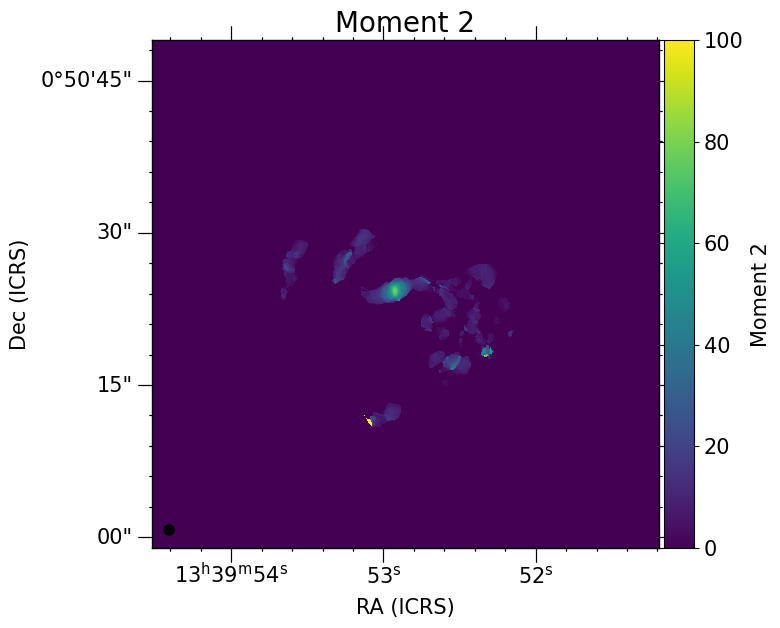

In [138]:
fig = aplpy.FITSFigure(momento_2, figsize=(7, 7))
fig.set_title('Moment 2',fontsize=20)
fig.show_colorscale(cmap='viridis',vmin = 0,vmax = 100)
fig.add_colorbar()
fig.colorbar.set_location('right')
fig.colorbar.set_width(0.3)
fig.colorbar.set_font(size='15')
fig.colorbar.set_axis_label_text('Moment 2')
fig.colorbar.set_axis_label_font(size = 15)
fig.axis_labels.set_font(size=15)
fig.tick_labels.set_font(size=15)
fig.ticks.set_length(10)
fig.add_beam()
fig.beam.set_color('black')